<a href="https://colab.research.google.com/github/HarshalPawar88/Evaluation-Projects/blob/main/Census_Income_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt,joblib
from scipy.stats import zscore
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score,average_precision_score
from sklearn.metrics import adjusted_mutual_info_score,balanced_accuracy_score,roc_curve,auc

In [3]:
import pandas as pd
df=pd.read_csv('https://raw.githubusercontent.com/dsrscientist/dataset1/master/census_income.csv')
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [4]:
df.shape

(32560, 15)

In [5]:
df.dtypes

Age                int64
Workclass         object
Fnlwgt             int64
Education         object
Education_num      int64
Marital_status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_gain       int64
Capital_loss       int64
Hours_per_week     int64
Native_country    object
Income            object
dtype: object

# **Exploratory Data Analysis**

Handling Null Values

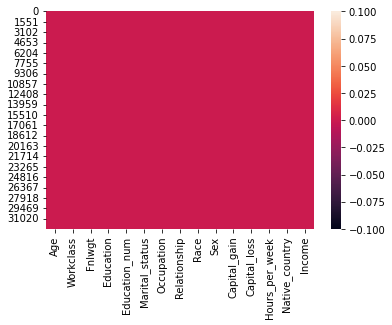

In [6]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.heatmap(df.isnull())

Checking for ? values in dataset

In [7]:
df.isin([' ?']).sum()

Age                  0
Workclass         1836
Fnlwgt               0
Education            0
Education_num        0
Marital_status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital_gain         0
Capital_loss         0
Hours_per_week       0
Native_country     583
Income               0
dtype: int64

Replacing ? values with Mode of the object columns

In [8]:
for col in ['Workclass', 'Occupation', 'Native_country']:
    df[col]=df[col].replace(' ?', df[col].mode()[0])

Getting the list of int64 columns in int_list

In [9]:
int_list=list(df.select_dtypes(['int64']).columns)

Univariate Analysis

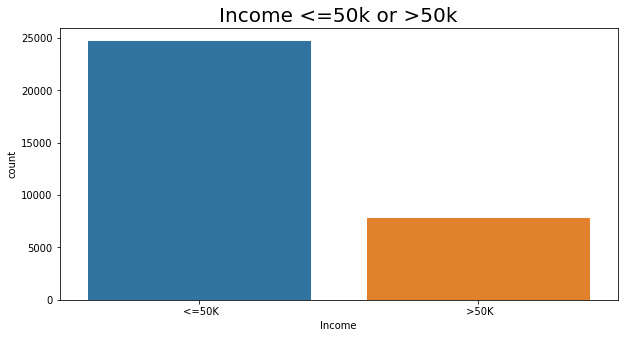

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5)) 
sns.countplot(x="Income", data=df) 
plt.title("Income <=50k or >50k", fontsize = 20)
plt.show()

People who earned less than or equal to 50k have more number than people who earned more than 50k

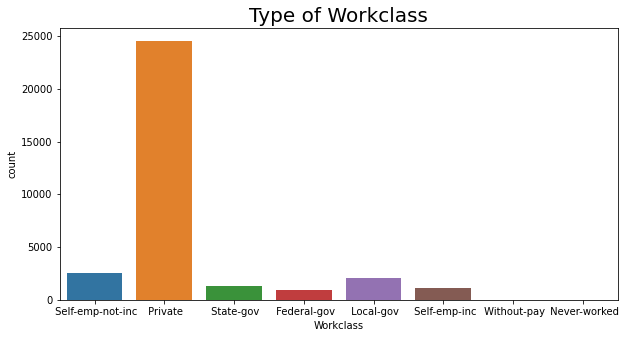

In [11]:
plt.figure(figsize = (10,5))
sns.countplot(x="Workclass", data=df)
plt.title("Type of Workclass", fontsize = 20)
plt.show()

Private Employee participated more

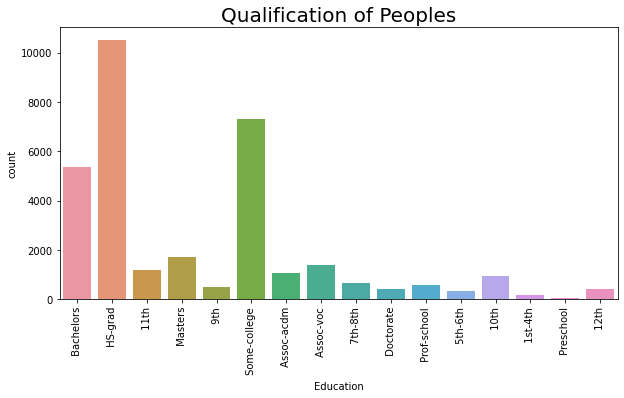

In [12]:
plt.figure(figsize = (10,5))
ax=sns.countplot(x="Education", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title("Qualification of Peoples", fontsize = 20)
plt.show()

The person who did HS-Grad is earning more than others

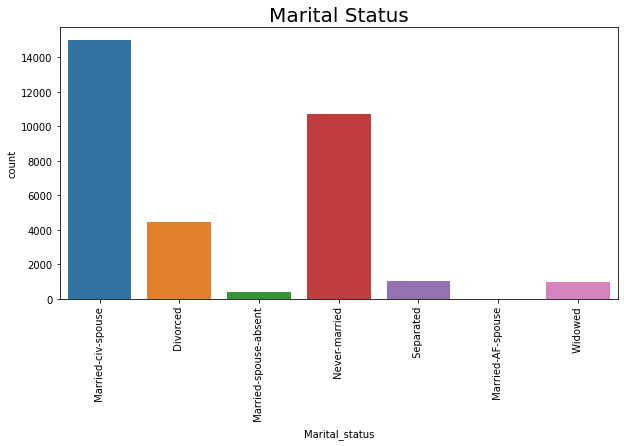

In [13]:
plt.figure(figsize = (10,5))
ax=sns.countplot(x="Marital_status", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title("Marital Status", fontsize = 20)
plt.show()

Married-civ-spouse have more income than others

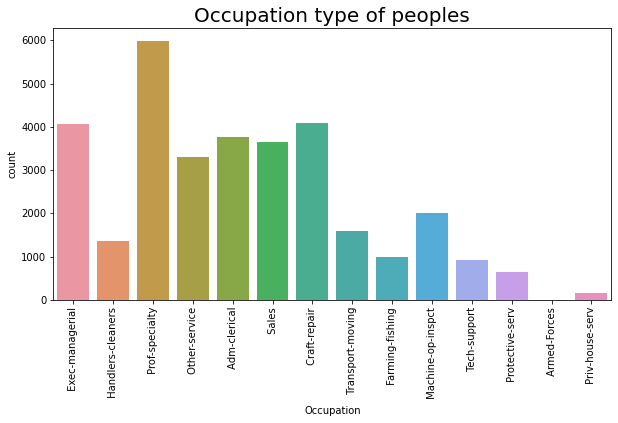

In [14]:
plt.figure(figsize = (10,5))
ax=sns.countplot(x="Occupation", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title("Occupation type of peoples", fontsize = 20)
plt.show()

People who's occupation is Prof-specialty have more number than others Occupation peoples.

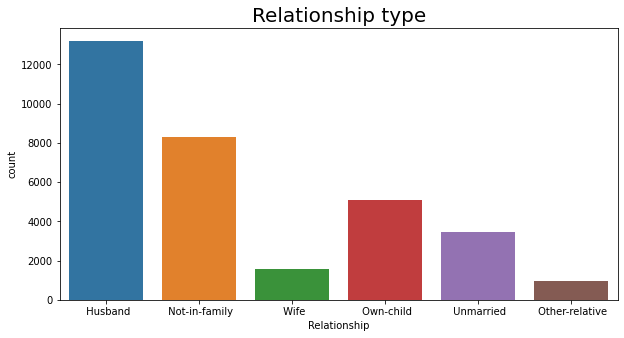

In [15]:
plt.figure(figsize = (10,5))
sns.countplot(x="Relationship", data=df)
plt.title("Relationship type", fontsize = 20)
plt.show()

Husband are earning more than any other person of family

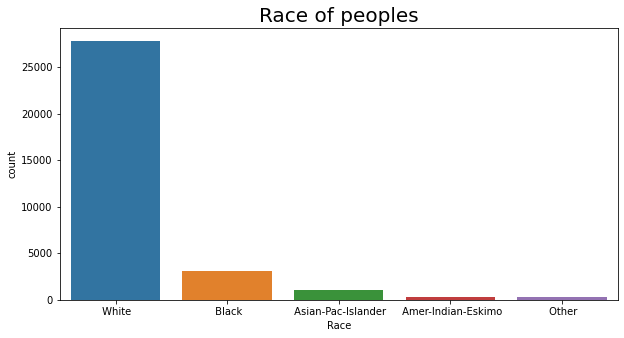

In [16]:
plt.figure(figsize = (10,5))
sns.countplot(x="Race", data=df)
plt.title("Race of peoples", fontsize = 20)
plt.show()

White peoples have more earning than other race of peoples

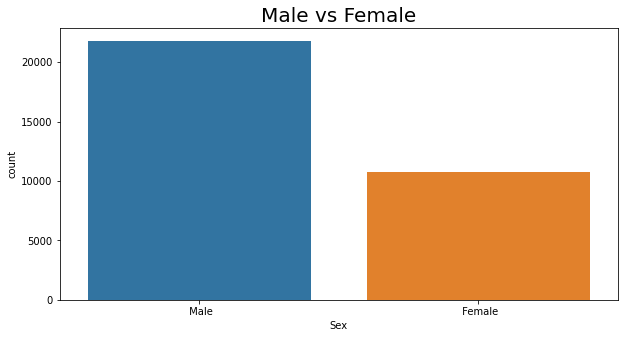

In [17]:
plt.figure(figsize = (10,5))
sns.countplot(x="Sex", data=df)
plt.title("Male vs Female", fontsize = 20)
plt.show()

Male earning more than Female

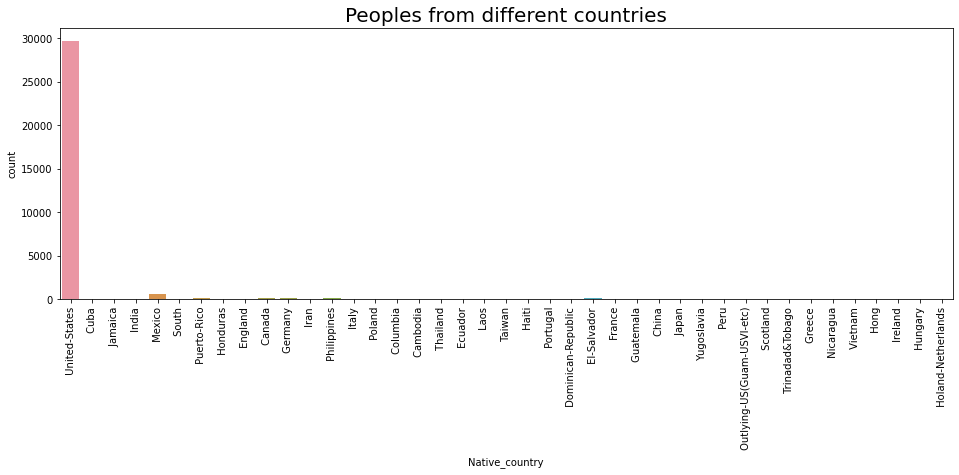

In [18]:
plt.figure(figsize = (16,5))
ax = sns.countplot(x="Native_country", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title("Peoples from different countries", fontsize = 20)
plt.show()

United-States peoples are earning more than other country peoples

### Bi-variate Analysis

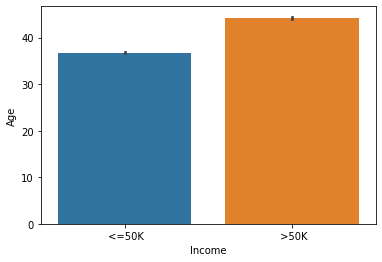

In [19]:
sns.barplot(x = 'Income', y = 'Age', data = df)

People who have age less than 40 are earning less than 50k and people who have age more than 40 are earning more than 50k

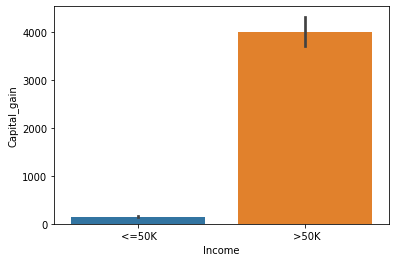

In [20]:
sns.barplot(x = 'Income', y = 'Capital_gain', data = df)

sns.barplot(x = 'Income', y = 'Capital_gain', data = df)

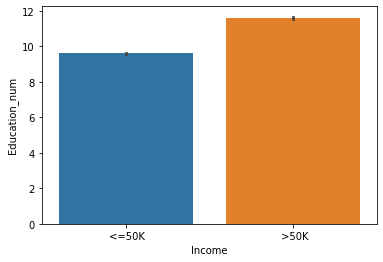

In [21]:
sns.barplot(x = 'Income', y = 'Education_num', data = df)

If Education num is less than 10 than income is less than 50k, If Education num is more than 11 than income will be more than 50k.

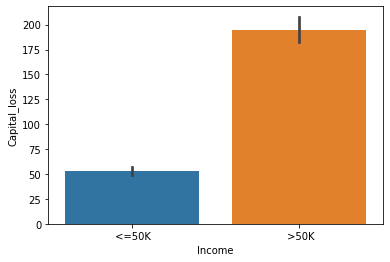

In [22]:
sns.barplot(x = 'Income', y = 'Capital_loss', data = df)

If Capital Loss is 50, income will be less than 50k and If Capital loss is more than 175, income will be more than 50k

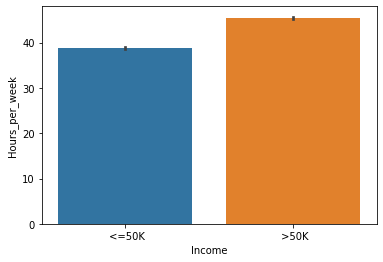

In [23]:
sns.barplot(x = 'Income', y = 'Hours_per_week', data = df)

If hours per week is less than 40 then Income will be less than 50k, If hours per week is more than 40 then Income will be more than 50k

In [24]:
df.describe()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Capital_gain and Capital_loss have min values 0 and 25,50 and 75% values are Zeros.

There is much difference in values of different columns, so we'll do scaling.

In [25]:
label_list=list(df.select_dtypes(['object']).columns)  
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder() 
for i in label_list:
    df[i] = le.fit_transform(df[i])

In [26]:
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,5,83311,9,13,2,3,0,4,1,0,0,13,38,0
1,38,3,215646,11,9,0,5,1,4,1,0,0,40,38,0
2,53,3,234721,1,7,2,5,0,2,1,0,0,40,38,0
3,28,3,338409,9,13,2,9,5,2,0,0,0,40,4,0
4,37,3,284582,12,14,2,3,5,4,0,0,0,40,38,0


shuffling the dataset This will Shuffle our dataset and it will avoid biasness of prediction

In [27]:
df = df.sample(frac=1, random_state = 0)

### Multi-Variate Analysis

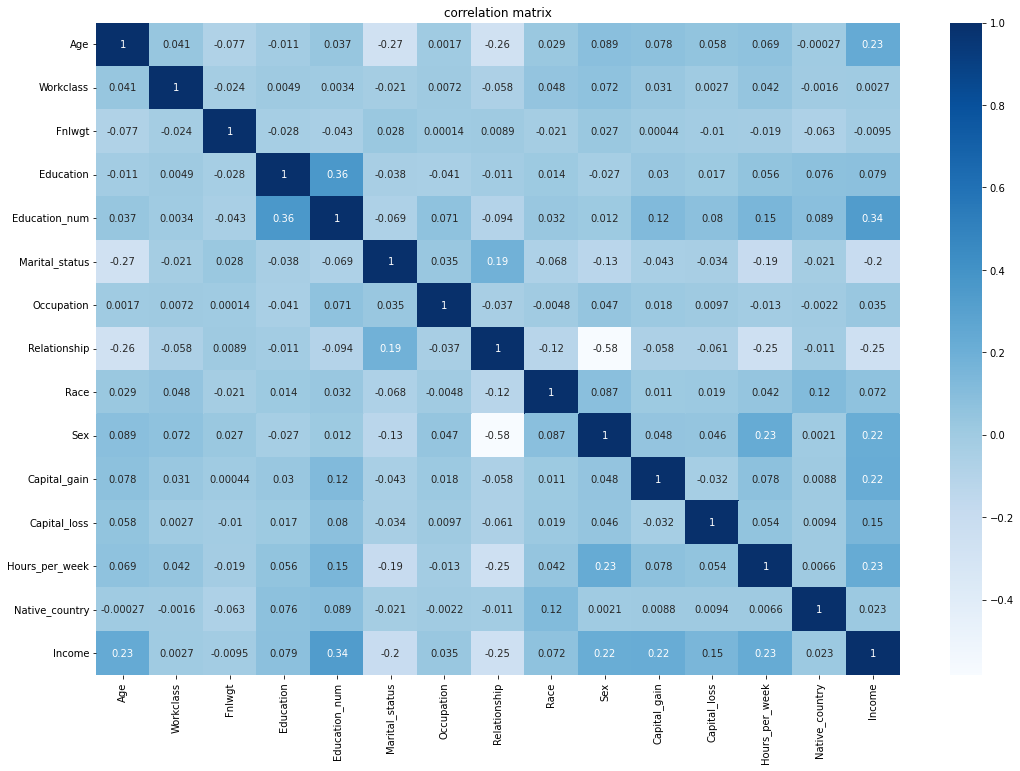

In [28]:
fig=plt.figure(figsize=(18,12))
hc=df.corr(method='pearson')
sns.heatmap(hc,annot=True,cmap="Blues")
plt.title("correlation matrix")
plt.show()

We can clearly see that there is not much correlation, even though Education_num have heighst corelation i.e. 34%

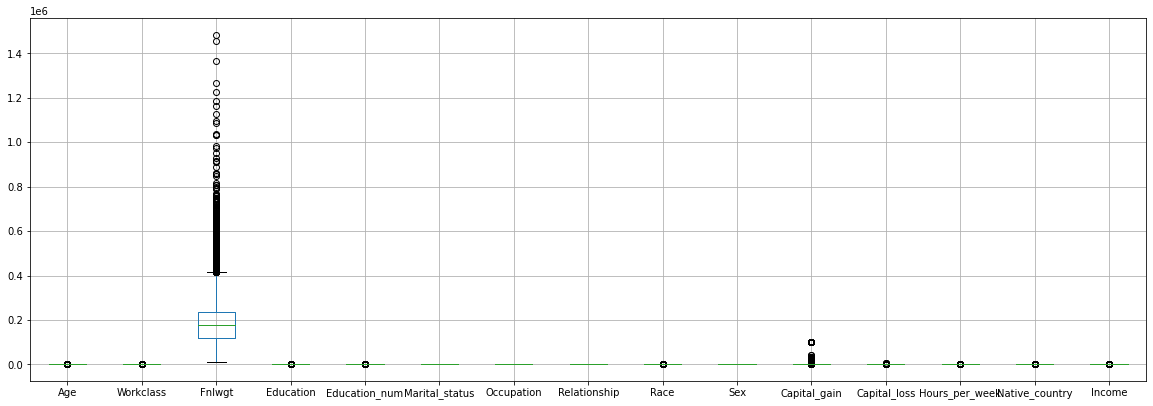

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
df.boxplot(figsize=[20,8])
plt.subplots_adjust(bottom=0.25)
plt.show()

In [30]:
import numpy as np
from scipy.stats import zscore
z=np.abs(zscore(df))
print(np.where(z>3))

(array([    2,     4,     9, ..., 32539, 32547, 32551]), array([13, 12,  0, ...,  8, 10,  8]))


In [31]:
df1=df[(z<3).all(axis = 1)]
print(df.shape)
print(df1.shape)

(32560, 15)
(27770, 15)


In [32]:
loss_percent=(32559-27769)/32559*100
print(loss_percent)

14.7117540465002


More than 14% of data we have to drop but this much amount of data is not good to drop.

In [33]:
x = df.drop("Income", axis=1)
y = df["Income"]

In [34]:
x.skew()

Age                0.558738
Workclass          0.076178
Fnlwgt             1.446972
Education         -0.934063
Education_num     -0.311630
Marital_status    -0.013448
Occupation         0.000536
Relationship       0.786784
Race              -2.435332
Sex               -0.719244
Capital_gain      11.953690
Capital_loss       4.594549
Hours_per_week     0.227636
Native_country    -4.243083
dtype: float64

In [35]:
from sklearn.preprocessing import PowerTransformer
PT=PowerTransformer() 
for i in int_list:
    if abs(x.loc[:,i].skew())>0.55:
        x.loc[:,i]=PT.fit_transform(x.loc[:,i].values.reshape(-1,1))

### Scaling

In [36]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler() 
new = scale.fit(x)  
scale_x = new.transform(x) 

scaled_x = pd.DataFrame(scale_x, index=x.index, columns=x.columns)
x=scaled_x
x.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country
22278,0.476686,0.571429,0.336528,1.000000,0.6,0.333333,0.307692,0.0,1.0,1.0,0.0,0.0,0.397959,0.95
8950,0.561811,0.428571,0.330628,1.000000,0.6,0.666667,0.230769,0.8,1.0,0.0,0.0,0.0,0.448980,0.95
7838,0.362885,0.428571,0.345955,0.333333,0.2,0.833333,0.692308,0.2,1.0,1.0,0.0,0.0,0.397959,0.30
16505,0.110668,0.428571,0.327069,1.000000,0.6,0.666667,0.000000,0.6,1.0,0.0,0.0,0.0,0.153061,0.95
19140,0.718571,0.428571,0.228073,0.333333,0.2,0.333333,0.538462,1.0,1.0,0.0,0.0,0.0,1.000000,0.95


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report,auc
import warnings
warnings.filterwarnings('ignore')
maxAccu=0
maxRS=0
for i in range(1,200):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=i)
    LR = LogisticRegression()
    LR.fit(x_train,y_train)
    predrf = LR.predict(x_test)
    acc = accuracy_score(y_test, predrf)
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
print("Best accuracy is",maxAccu," on Random_state ",maxRS)

Best accuracy is 0.8249385749385749  on Random_state  101


In [38]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=maxRS)

In [39]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [40]:
model=[LogisticRegression(),KNeighborsClassifier(),BernoulliNB(),SVC(),DecisionTreeClassifier(),RandomForestClassifier()]
for m in model:
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    print('accuracy score of ->', m)
    print(accuracy_score(y_test,pred))
    print(confusion_matrix(y_test,pred))
    print(classification_report(y_test,pred))
    score=cross_val_score(m,x,y,cv=5)
    print(score)
    print(score.mean())
    print("Difference between Accuracy score and cross validation score is - ",accuracy_score(y_test,pred)-score.mean())

accuracy score of -> LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
0.8249385749385749
[[6988  453]
 [1257 1070]]
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      7441
           1       0.70      0.46      0.56      2327

    accuracy                           0.82      9768
   macro avg       0.78      0.70      0.72      9768
weighted avg       0.81      0.82      0.81      9768

[0.81388206 0.81695332 0.81787469 0.81541769 0.817414  ]
0.8163083538083538
Difference between Accuracy score and cross validation score is -  0.00863022113022116
accuracy score of -> KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     me

Random Forest Classifier have the heighst Accuracy and cross validation Score i.e. 85.97%

In [41]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {"max_depth":[1,2,3,4,5,6,7,8,9,10,15,20],
              "max_features": [3,5,7,9],
              "min_samples_leaf":[2,3,4,5,6]}

clf = RandomizedSearchCV(RandomForestClassifier(), parameters)
clf.fit(x_train,y_train) #fitting train and test data
clf.best_params_  #Best parameters

{'max_depth': 15, 'max_features': 9, 'min_samples_leaf': 6}

In [42]:
clf_pred=clf.best_estimator_.predict(x_test)

In [43]:
accuracy_score(y_test,clf_pred)

0.8658886158886159

In [44]:
print(accuracy_score(y_test,clf_pred))
print(confusion_matrix(y_test,clf_pred))
print(classification_report(y_test,clf_pred))

0.8658886158886159
[[7017  424]
 [ 886 1441]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      7441
           1       0.77      0.62      0.69      2327

    accuracy                           0.87      9768
   macro avg       0.83      0.78      0.80      9768
weighted avg       0.86      0.87      0.86      9768



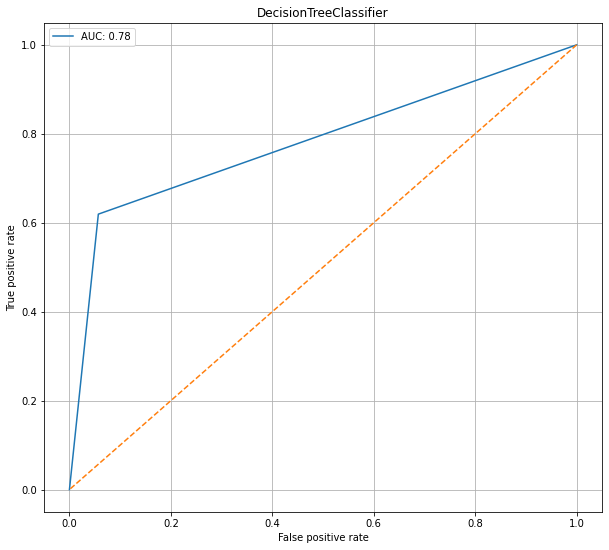

In [45]:
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
fpr,tpr,thresholds=roc_curve(y_test,clf_pred) # calculating fpr, tpr
rf_auc = auc(fpr, tpr) #Model Accuracy
plt.figure(figsize=(10,9)) #plotting the figure, size of 10*9
plt.plot(fpr, tpr, label = 'AUC: %0.2f' % rf_auc)
plt.plot([1,0],[1,0], linestyle = '--')
plt.legend(loc=0) #adding accuracy score at bottom right
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('DecisionTreeClassifier')
plt.grid() #adding the grid

In [46]:
import joblib
joblib.dump(clf.best_estimator_,"Census.obj")
SVR_from_joblib=joblib.load("Census.obj")
Predicted = SVR_from_joblib.predict(x_test)
Predicted

array([1, 0, 1, ..., 0, 0, 0])

In [47]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.DataFrame([SVR_from_joblib.predict(x_test)[:],y_test[:]],index=["Predicted","Original"])

0     1     2     3     4     5     6     7     8     9     10    \
Predicted     1     0     1     0     0     0     0     0     0     1     0   
Original      1     0     0     0     0     0     0     0     0     1     0   

           11    12    13    14    15    16    17    18    19    20    21    \
Predicted     0     1     1     0     0     0     0     0     0     0     0   
Original      0     1     1     0     0     0     0     0     0     1     0   

           22    23    24    25    26    27    28    29    30    31    32    \
Predicted     0     0     0     0     0     0     1     1     0     0     0   
Original      0     0     0     0     0     0     1     1     0     0     0   

           33    34    35    36    37    38    39    40    41    42    43    \
Predicted     0     1     0     0     0     0     0     0     1     1     0   
Original      0     1     1     0     0     0     0     0     0     1     0   

           44    45    46    47    48    49    50    51    52    53    54    \
Predicted     0     0     0     0     0     0     0     0     0     0     0   
Original      0     0     0     0     0     0     0     0     0     0     0   

           55    56    57    58    59    60    61    62    63    64    65    \
Predicted     0     0     0     0     0     0     0     0     0     0     0   
Original      0     0     0     1     0     0     0     0     0     0     0   

           66    67    68    69    70    71    72    73    74    75    76    \
Predicted     0     0     0     0     0     1     0     0     1     0     0   
Original      0     0     0     0     0     0     0     0     1     0     0   

           77    78    79    80    81    82    83    84    85    86    87    \
Predicted     0     0     1     0     0     1     1     0     0     0     0   
Original      0     0     0     0     0     0     1     0     0     0     0   

           88    89    90    91    92    93    94    95    96    97    98    \
Predicted     0     0     0     1     0     1     0     0     0     0     0   
Original      0     0     0     1     0     1     0     0     0     0     1   

           99    100   101   102   103   104   105   106   107   108   109   \
Predicted     1     0     0     0     1     0     0     0     0     0     0   
Original      0     0     1     1     1     0     0     0     0     0     0   

           110   111   112   113   114   115   116   117   118   119   120   \
Predicted     0     0     0     0     0     0     0     1     0     0     0   
Original      0     0     0     0     1     0     1     1     0     0     0   

           121   122   123   124   125   126   127   128   129   130   131   \
Predicted     0     0     0     0     1     0     0     0     0     0     1   
Original      0     0     0     0     0     1     0     1     0     0     1   

           132   133   134   135   136   137   138   139   140   141   142   \
Predicted     0     1     0     0     0     0     0     0     0     0     0   
Original      0     1     0     0     0     0     0     0     0     0     0   

           143   144   145   146   147   148   149   150   151   152   153   \
Predicted     0     0     0     1     0     1     0     0     0     0     0   
Original      1     0     0     1     0     1     0     0     0     1     0   

           154   155   156   157   158   159   160   161   162   163   164   \
Predicted     0     1     0     0     1     0     0     1     0     1     0   
Original      0     0     0     0     1     0     0     0     1     1     0   

           165   166   167   168   169   170   171   172   173   174   175   \
Predicted     0     0     0     0     0     0     0     0     1     0     0   
Original      0     0     0     0     0     0     0     0     1     0     0   

           176   177   178   179   180   181   182   183   184   185   186   \
Predicted     1     0     0     0     0     0     0     0     0     0     0   
Original      0     0     0     0     1     0